# Lithology Facies Classification

This notebook is intended for the purpose of experimentation, i.e:
- understanding the big data (>1 million rows)
- feature engineering
- model training

In [1]:
# importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from src.score import score
import random


# model
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import f1_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [2]:
# defining dictionary to map our predictions to, for our custom score function
lithology_keys = {
    30000: 0,
    65030: 1,
    65000: 2,
    80000: 3,
    74000: 4,
    70000: 5,
    70032: 6,
    88000: 7,
    86000: 8,
    99000: 9,
    90000: 10,
    93000: 11
}

In [3]:
# importing train and test data
X_train = pd.read_csv("../data/train.csv", sep=";")
target = X_train['FORCE_2020_LITHOFACIES_LITHOLOGY']
target = target.map(lithology_keys)
X_train = X_train.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY', 'FORCE_2020_LITHOFACIES_CONFIDENCE'], axis=1)

X_test = pd.read_csv("../data/test.csv", sep=";")
y_test = pd.read_csv("../data/test_targets.csv", sep=";")['FORCE_2020_LITHOFACIES_LITHOLOGY']
y_test = y_test.map(lithology_keys)

In [4]:
# function for calculating % of missing values per feature in the dataset
def return_missing_values(df):
    for col in df.columns:
        missing = df[col].isna().sum()
        print(f"% missing in {col}: {missing/len(df):.1%}")
        
return_missing_values(X_train)

% missing in WELL: 0.0%
% missing in DEPTH_MD: 0.0%
% missing in X_LOC: 0.9%
% missing in Y_LOC: 0.9%
% missing in Z_LOC: 0.9%
% missing in GROUP: 0.1%
% missing in FORMATION: 11.7%
% missing in CALI: 7.5%
% missing in RSHA: 46.1%
% missing in RMED: 3.3%
% missing in RDEP: 0.9%
% missing in RHOB: 13.8%
% missing in GR: 0.0%
% missing in SGR: 94.1%
% missing in NPHI: 34.6%
% missing in PEF: 42.6%
% missing in DTC: 6.9%
% missing in SP: 26.2%
% missing in BS: 41.7%
% missing in ROP: 54.3%
% missing in DTS: 85.1%
% missing in DCAL: 74.5%
% missing in DRHO: 15.6%
% missing in MUDWEIGHT: 73.0%
% missing in RMIC: 85.0%
% missing in ROPA: 83.6%
% missing in RXO: 72.0%


There are quite a number of features with missing values > 50%. Therefore, these features will be dropped.

In the following cell, a function will be create to train an tune the hyper-parameters of an xgboost classifier. This approach was taken for ease of use, and adaptability, i.e we can chart few paramters easily and re-run function.



In [5]:
# function for training model, and getting best hyper-paramters
def train_model(df, target, random_seed=53, n_iter=20):
    np.random.seed(random_seed)
    '''Train a Random Forest Lithofacies Classifier'''

    # columns to drop based on missing values -> other features added because of low feature importances score / poor model performance during initial experimentation
    #cols_to_drop =["SGR", "DTS", "ROP", "DCAL", "MUDWEIGHT", "RMIC", "ROPA", "RXO", "BS", "WELL", "FORMATION", "GROUP"]
    cols_to_drop =["SGR", "DTS", "ROP", "DCAL", "MUDWEIGHT", "RMIC", "ROPA", "RXO", "BS"]
    
    # dropping features with >50% null values -> not necessary considering that features identified during initial experimentation will be selected below, but included to know which features were specifically ignored
    df = df.drop(cols_to_drop, axis=1)
    
    # getting list of numerical attributes
    num_attribs = ['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'RSHA', 'RMED', 'RDEP',
       'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'DRHO']
    cat_attribs = ["FORMATION", "GROUP"]

    
    # Transformer class for dataframe selection based on attribute type
    class DataFrameSelector(BaseEstimator, TransformerMixin):
        def __init__(self, attrib_names):
            self.attrib_names = attrib_names
            
        def fit(self, X, y=None):
            return self
        
        def transform(self, X):
            return X[self.attrib_names]
    
    # Transformer class to handle outliers in the dataset. If any instance is below or above the threshold set, they are replaced
    class ReplaceOutliers(BaseEstimator, TransformerMixin):
        def __init__(self, ):
            pass
            
        def fit(self, X, y=None):
            return self
        
        def transform(self, X):
            low = 0.01
            high = 0.99
            X = pd.DataFrame(X, columns=[*range(X.shape[1])])
            for col in X:
                X[col] = np.where((X[col] > X[col].quantile(high)), X[col].quantile(high), X[col])
                X[col] = np.where((X[col] < X[col].quantile(low)), X[col].quantile(low), X[col])
            return X
                
    
    # numerical pipeline to apply Transformers to numerical features
    num_pipeline = Pipeline([
        ("Select dataframe", DataFrameSelector(num_attribs)),
        ("imputer", SimpleImputer(strategy="median")),
        ("outliers", ReplaceOutliers()),
        ("scaler", StandardScaler()),
        #('poly', PolynomialFeatures(degree=2, include_bias=False)) 
    ])

    cat_pipeline = Pipeline([
        ("Select dataframe", DataFrameSelector(cat_attribs)),
        ("OneHot encode", OneHotEncoder(handle_unknown="ignore"))
    ])
    
    
    full_pipeline = FeatureUnion(transformer_list=[
        ("numeric pipeline", num_pipeline),
        ("category pipeline", cat_pipeline)
    ])
    
    
    # applying transformation pipeline on entire dataset
    train_full = full_pipeline.fit_transform(df)

    # spitting dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(train_full, target, test_size=0.25, random_state=random_seed, stratify=target) 
    
    # creating an xgboost data matrix to optimize training
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    # evaluation set
    evals = [(dtest, 'eval'), (dtrain, 'train')]
    
    # default params
    params = {
        "seed": random_seed,
        "objective": "multi:softmax",
        "num_class": 12,
        "max_depth": 10,
        "eta": 0.2,
        "eval_metric": "mlogloss",
        "device": "cuda",
        'reg_lambda': 1500,
        
    }
    
    # paramter grid for hyper-paramter tuning
    param_grid = {
        'max_depth': [6, 8, 10, 12, 14], 
        'eta': [0.01, 0.05, 0.1, 0.2, 0.3], 
        'reg_lambda': [500, 1000, 1500, 2000, 2500], 
        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0], 
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0], 
        'min_child_weight': [1, 5, 10, 15], 
        'gamma': [0, 0.1, 0.2, 0.3, 0.4], 
        'n_estimators': [100, 200, 300]
    }
    
    # function to perform random grid search using param grid -> add y_test=y_test,
    def random_search(params=params, dtrain=dtrain, dtest=dtest,y_test=y_test, num_boost_round=100, 
                      early_stopping_rounds=20, param_grid=param_grid, evals=evals, n_iter=n_iter):
        """Performs Randomized search"""
        
        best_params = None
        best_score = -1_000
        best_model = None
        
        for _ in range(n_iter):
            current_params = params.copy()
            for key in param_grid.keys():
                current_params[key] = random.choice(param_grid[key])

            # training the model
            model = xgb.train(current_params, dtrain, num_boost_round=num_boost_round, evals=evals, early_stopping_rounds=early_stopping_rounds, verbose_eval=False)

            # making predictions on test set to calculate custom score
            pred = model.predict(dtest)
                        
            # get the best custom score
            score_ = score(y_test.values, pred)
            if score_ > best_score:
                best_score = score_
                best_params = current_params
                best_model = model

        return best_params, best_model
    
    best_params, model = random_search()
    
    return model, best_params, full_pipeline

In [6]:
# training and hyper-parameter tuning -> change n_iter to number of randomized search you want to perform
model, params, transformer = train_model(X_train, target, n_iter=1)

/home/ubuntu/miniconda3/envs/oil/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:42:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


**Note: The best parameters have already been selected and used in the python training script.**

Change `n_iter` above to perform another randomized search

In [7]:
# best param for "n_iter" searches
print(f"Best params:")
params

Best params:


{'seed': 53,
 'objective': 'multi:softmax',
 'num_class': 12,
 'max_depth': 14,
 'eta': 0.05,
 'eval_metric': 'mlogloss',
 'device': 'cuda',
 'reg_lambda': 1000,
 'subsample': 0.8,
 'colsample_bytree': 0.8,
 'min_child_weight': 15,
 'gamma': 0.1,
 'n_estimators': 300}

In [8]:
# function to perform transformation
def apply_transformer(test, transformer):
    test = transformer.transform(test)
    test = xgb.DMatrix(test)
    return test

### Evaluation

There are two (2) test sets available. Both test sets are significantly different from each other and the train set due to different lithology distributions.

The custom trained model will be evaluated on both test sets in the next notebook. For now, the trained model from the experimentation will be evaluated on the train and one of the test sets to have some kind of basis for comparison.

In [9]:
# evaluating the model on the train set

X_train_transformed = apply_transformer(X_train, transformer)
pred_train = model.predict(X_train_transformed)
print(f"Custom score: {score(target.values, pred_train)}")
print(f"f1-score: {f1_score(target.values, pred_train, average='weighted'):.1%}")

Custom score: -0.31821678736893544
f1-score: 87.3%


as expected the model should perform well on the train set. What about the test set ?

In [10]:
# evaluating on the provided test set

X_test_transformed = apply_transformer(X_test, transformer)
pred_test = model.predict(X_test_transformed)
print(f"Custom score: {score(y_test.values, pred_test)}")
print(f"f1-score: {f1_score(y_test.values, pred_test, average='weighted'):.1%}")

Custom score: -0.5347559326246838
f1-score: 76.8%


as expected, model performance on one of the test set is significantly poorer when compared to that on the train set

In [11]:
# classification report
print(classification_report(target.values, pred_train))

/home/ubuntu/miniconda3/envs/oil/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ubuntu/miniconda3/envs/oil/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.85      0.84      0.85    168937
           1       0.81      0.63      0.71    150455
           2       0.90      0.97      0.93    720803
           3       0.84      0.69      0.76     33329
           4       0.71      0.01      0.03      1688
           5       0.86      0.64      0.74     56320
           6       0.90      0.88      0.89     10513
           7       0.98      0.99      0.99      8213
           8       0.91      0.81      0.86      1085
           9       0.80      0.84      0.82     15245
          10       0.92      0.29      0.44      3820
          11       0.00      0.00      0.00       103

    accuracy                           0.88   1170511
   macro avg       0.79      0.63      0.67   1170511
weighted avg       0.88      0.88      0.87   1170511



/home/ubuntu/miniconda3/envs/oil/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


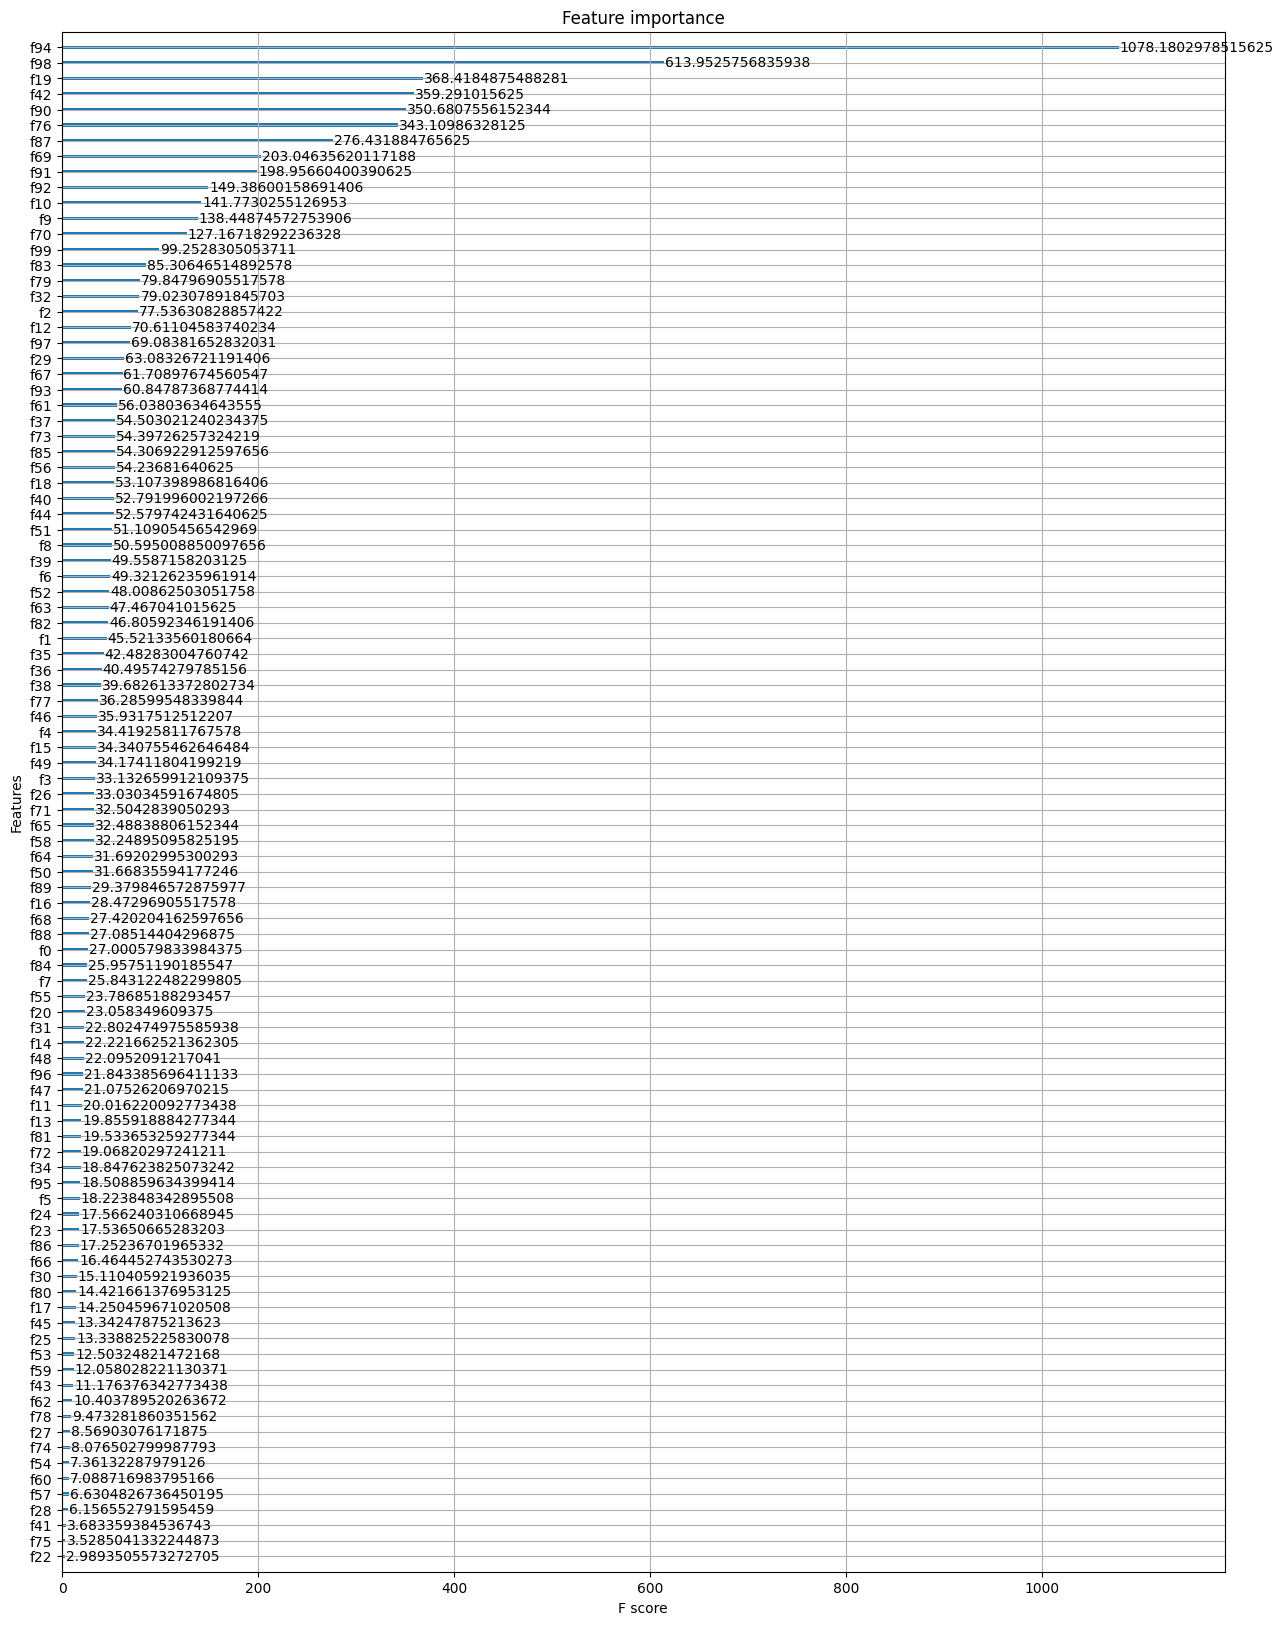

In [12]:
# feature importances

fig, ax = plt.subplots(figsize=(15, 20))
plot_importance(model, importance_type='gain', ax=ax)
plt.show()